In [1]:
# this version of the DANN utilzes two disciminators, each affecting the weight updates of the encoder
# one discriminator, as before is adversarial to the encoder and reflects the ability to discriminate technology
# the other one is not and disrciminates based on patient response (yes vs no)

In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.callbacks import EarlyStopping
import seaborn as sb
from scipy.spatial.distance import pdist
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import time
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

adata = sc.read('/tmp/work/RCproject_code/sce_export.h5ad')
epoch_count = 0

#exclude partial
adata = adata[~adata.obs['Response'].isin(['partial']), :]

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2024-10-23 11:53:18.641398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `a

In [3]:
#params
simplifly_categories = True
dropout_rate = 0.1  #dropout rate for regulraization
low_dim_rep_number = 128
current_lambda_value = 10
test_set_size = 0.2

In [4]:
# generate numerical values for each batch category
# set up categories variable
categories_technology = adata.obs['batch']

#collpse the categories to microARRAY vs sequencing

if simplifly_categories:
    category_map = {'GSE133057': 'micro', 'GSE145037': 'micro', 'GSE150082': 'micro','GSE190826':'seq','GSE209746':'seq',
                    'GSE45404_GPL1': 'micro', 'GSE45404_GPL2': 'micro', 'GSE93375': 'micro','GSE94104': 'micro'}
    categories_technology = np.vectorize(category_map.get)(categories_technology)
    
# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Fit and transform the categories to integers
numerical_categories_technology = label_encoder.fit_transform(categories_technology)
print(numerical_categories_technology.shape)

#do the same for the response variable
categories_outcome = adata.obs['Response']
numerical_categories_outcome = label_encoder.fit_transform(categories_outcome)
print(numerical_categories_technology.shape)

(410,)
(410,)


In [5]:
#normalizaiton
gene_expression_data = adata.layers['scalelogcounts']

# Min-max normalization
scaler = MinMaxScaler()
gene_expression_data = scaler.fit_transform(gene_expression_data)
number_genes = adata.shape[1]
input_dim = number_genes

In [6]:
adata.obs['numerical_categories_technology'] = numerical_categories_technology
adata.obs['numerical_categories_outcome'] = numerical_categories_outcome

/tmp/ipykernel_3098564/855193586.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['numerical_categories_technology'] = numerical_categories_technology


In [7]:
just_meta_data = adata.obs

In [8]:
indices = [i for i, s in enumerate(adata.obs['Response']) if s in ["yes", "no"]]
y = adata.obs['Response'][indices]
y = [1 if x == "yes" else 0 for x in y]
y = np.array(y)
X = gene_expression_data[indices]

X_train, X_test, y_train, y_test = train_test_split(X, just_meta_data, test_size=test_set_size, random_state=42)

y_train_outcome = y_train['numerical_categories_outcome']
y_test_outcome = y_test['numerical_categories_outcome']

y_train_tech = y_train['numerical_categories_technology']
y_test_tech = y_test['numerical_categories_technology']

/tmp/ipykernel_3098564/1583094780.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = adata.obs['Response'][indices]


In [9]:
# y_test.shape
unique_items, counts = np.unique(y_test_outcome, return_counts=True)
counts_table = dict(zip(unique_items, counts))
print(counts_table)

unique_items, counts = np.unique(y_train_outcome, return_counts=True)
counts_table = dict(zip(unique_items, counts))
print(counts_table)


{0: 56, 1: 26}
{0: 211, 1: 117}


In [10]:
cat_count_tech = len(np.unique(numerical_categories_technology))

In [11]:
# current correlations betweent the groups

current = gene_expression_data
if len(np.unique(numerical_categories_technology)) == 3:
    #caculate the average expression array for the categories of interest
    seq1_mean = np.mean(current[np.where(categories_technology == 'seq1')],axis = 0, keepdims = True)
    seq2_mean = np.mean(current[np.where(categories_technology == 'seq2')],axis = 0, keepdims = True)
    micro_mean = np.mean(current[np.where(categories_technology == 'micro')],axis = 0, keepdims = True)
    #calculate the pearson correlations
    seq1_v_micro, pval = pearsonr(seq1_mean.ravel(), micro_mean.ravel())
    seq1_v_seq2, pval = pearsonr(seq1_mean.ravel(), seq2_mean.ravel())
    seq2_v_micro, pval = pearsonr(seq2_mean.ravel(), micro_mean.ravel())
    
    print(seq1_v_micro)
    print(seq1_v_seq2)
    print(seq2_v_micro)

elif len(np.unique(numerical_categories_technology)) == 2:
    #caculate the average expression array for the categories of interest
    seq_mean = np.mean(current[np.where(categories_technology == 'seq')],axis = 0, keepdims = True)
    micro_mean = np.mean(current[np.where(categories_technology == 'micro')],axis = 0, keepdims = True)
    #calculate the pearson correlations
    seq_v_micro, pval = pearsonr(seq_mean.ravel(), micro_mean.ravel())
    
    print(seq_v_micro)


0.3545861517315691


In [12]:
# define the network architecture with functions for the encoder, decoder and discriminator

# Define the input shape
input_shape = (gene_expression_data.shape[1],)[0]  # Number of genes

# Define the encoder function
def build_encoder():
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))  # Input shape matches your data

    # First layer with dropout
    model.add(layers.Dense((low_dim_rep_number*8), activation='linear'))  # Increased units
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))  # Add dropout for regularization

    # Second layer
    model.add(layers.Dense((low_dim_rep_number*4), activation='linear'))  # Increased units
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))  # Add dropout

    # Third layer
    model.add(layers.Dense((low_dim_rep_number*2), activation='linear'))  # Increased units
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))  # Add dropout

    # Encoded representation layer
    model.add(layers.Dense(low_dim_rep_number, activation='linear'))  # Output encoded representation
    return model

# Define the decoder function (adjusted as discussed)
def build_decoder():    
    model = models.Sequential()
    model.add(layers.Input(shape=(low_dim_rep_number,)))  # Input shape should match the output of the encoder
    model.add(layers.Dense((low_dim_rep_number*2), activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense((low_dim_rep_number*4), activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(input_shape, activation='sigmoid'))  # Output layer should match the input shape of the original data
    return model

## defines is the discriminator function
def build_domain_classifier(num_domains):
    model = keras.Sequential()
    model.add(layers.Input(shape=low_dim_rep_number))
    
    #Increased capacity with more units and layers
    model.add(layers.Dense((low_dim_rep_number*2), activation='relu'))  # Increased units and changed activation
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))  # Added dropout for regularization
    
    model.add(layers.Dense((low_dim_rep_number/2), activation='relu'))  # Increased units
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))  # Added dropout for regularization

    model.add(layers.Dense((low_dim_rep_number/4), activation='relu'))  # Increased units
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))  # Added dropout for regularization
    
    model.add(layers.Dense((low_dim_rep_number/8), activation='relu'))  # Maintain units
    model.add(layers.BatchNormalization())
    
    # Output layer with softmax activation
    model.add(layers.Dense(num_domains, activation='softmax'))  # num_domains is the number of classes
    
    return model

#uses a sigmoid output since there are only two outcomes
def build_outcome_classifier():
    model = keras.Sequential()
    model.add(layers.Input(shape=low_dim_rep_number))
    
    # Add more hidden layers and increase units with Leaky ReLU
    model.add(layers.Dense((low_dim_rep_number * 4)))
    model.add(layers.LeakyReLU(alpha=0.1))  # Leaky ReLU helps with vanishing gradients
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense((low_dim_rep_number * 2)))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    # Reduce units in subsequent layers with Leaky ReLU
    model.add(layers.Dense((low_dim_rep_number * 1)))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    # Output layer for binary classification with sigmoid activation
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

#gradient reversal takes lambda as an argument, will ensure that the encoder is trained to work against the discimatinator when the lambda is positive
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_value=current_lambda_value, **kwargs):
        self.lambda_value = lambda_value
        super(GradientReversalLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Define custom gradient behavior
        @tf.custom_gradient
        def reverse_gradients(x):
            # Forward pass: output is just the input
            def grad(dy):
                # Gradient computation: reversed and scaled by lambda_value
                return -self.lambda_value * dy
            return x, grad
        
        return reverse_gradients(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({"lambda_value": self.lambda_value})
        return config

In [13]:
# Define the encoder, decoder, and discriminator (assuming these functions are defined as in previous examples)
encoder = build_encoder()  # Assuming build_encoder() is defined
decoder = build_decoder()  # Assuming build_decoder() is defined
discriminator = build_domain_classifier(cat_count_tech)  # Assuming build_domain_classifier() is defined
outcome_discriminator = build_outcome_classifier()

# Optimizers for each model
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
outcome_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


# Assuming you have 1000 training samples as an example
num_samples = adata.shape[0]  # Replace this with your actual number of samples
batch_size = 128  #determines how many samples are processed per batch, each epoch will process multiple batches
batch_size = adata.shape[0]

# Calculate the number of steps per epoch
num_steps_per_epoch = num_samples // batch_size

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the outcome discriminator
outcome_discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Combine the encoder and decoder into a single model (autoencoder)
autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder.output))

# Compile the autoencoder with the appropriate loss function (e.g., mean squared error)
autoencoder.compile(optimizer=encoder_optimizer, loss='mean_squared_error')

num_domains = len(np.unique(categories_technology))

In [55]:
num_epochs = 1000000
report_frequency = 1000
disc_loss_threshold = np.log(cat_count_tech)
accuracy_threshold = 1

# Define the training step
def train_step(data, disc_labels, outcome_labels):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass through the encoder and decoder
        encoded_output = encoder(data)
        reconstructed_output = decoder(encoded_output)

        # Compute the autoencoder loss
        ae_loss = tf.keras.losses.mean_squared_error(data, reconstructed_output)
        ae_loss = tf.reduce_mean(ae_loss)  # Average over the batch
        
        # Forward pass through the GRL and discriminator
        grl_output = GradientReversalLayer()(encoded_output)
        domain_predictions = discriminator(grl_output)

        # Compute the discriminator loss
        disc_loss = tf.keras.losses.sparse_categorical_crossentropy(disc_labels, domain_predictions)
        disc_loss = tf.reduce_mean(disc_loss)  # Average over the batch

        # Forward pass through the biological discriminator
        outcome_predictions = outcome_discriminator(encoded_output)

        # Compute the biological discriminator loss (no gradient reversal)
        outcome_loss = tf.keras.losses.binary_crossentropy(outcome_labels, outcome_predictions)
        outcome_loss = tf.reduce_mean(outcome_loss)  # Average over the batch

    # Compute gradients for the autoencoder (only for ae_loss)
    encoder_grads_ae = tape.gradient(ae_loss, encoder.trainable_variables)
    decoder_grads = tape.gradient(ae_loss, decoder.trainable_variables)

    # Compute gradients for the discriminator
    discriminator_grads = tape.gradient(disc_loss, discriminator.trainable_variables)

    # Compute gradients for the outcome discriminator
    outcome_discriminator_grads = tape.gradient(outcome_loss, outcome_discriminator.trainable_variables)

    # Compute gradients for the encoder from the discriminator loss
    encoder_grads_disc = tape.gradient(disc_loss, encoder.trainable_variables)

    # Compute gradients for the encoder from the outcome loss (no reversal)
    encoder_grads_outcome = tape.gradient(outcome_loss, encoder.trainable_variables)

     # Combine encoder gradients from both losses
    encoder_grads = [g_ae + g_domain + g_out for g_ae, g_domain, g_out in zip(encoder_grads_ae, encoder_grads_disc, encoder_grads_outcome)]

    # Update weights
    encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))
    decoder_optimizer.apply_gradients(zip(decoder_grads, decoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))
    outcome_discriminator_optimizer.apply_gradients(zip(outcome_discriminator_grads, outcome_discriminator.trainable_variables))

    # Calculate accuracy for the outcome discriminator
    predicted_outcome_labels = tf.cast(outcome_predictions > 0.5, tf.float32)  # Threshold at 0.5
    
    # Cast outcome_labels to float to match the type of predicted_outcome_labels
    outcome_labels_float = tf.cast(outcome_labels, tf.float32)
    
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_outcome_labels, outcome_labels_float), tf.float32))

    return ae_loss, disc_loss, outcome_loss, accuracy


# Training loop
for epoch in range(num_epochs):
    epoch_count += 1
    total_disc_loss = 0.0  # To accumulate discriminator loss
    total_accuracy = 0.0  # To accumulate outcome accuracy

    for step in range(num_steps_per_epoch):
        # Get your batch data
        data = X_train[step * batch_size:(step + 1) * batch_size]
        disc_labels = y_train_tech[step * batch_size:(step + 1) * batch_size]
        outcome_labels = y_train_outcome[step * batch_size:(step + 1) * batch_size]
        outcome_labels = tf.expand_dims(outcome_labels, axis=-1)  # Reshape to match the logits shape
        
        # Perform the training step and capture losses and accuracy
        ae_loss, disc_loss, outcome_loss, accuracy = train_step(data, disc_labels, outcome_labels)

        # Accumulate losses and accuracy
        total_disc_loss += disc_loss.numpy()
        total_accuracy += accuracy.numpy()

        # Print the losses and accuracy
        if epoch_count % report_frequency == 0:
            print(f'Epoch {epoch}, Step {step}, AE Loss: {ae_loss.numpy()}, Disc Loss: {disc_loss.numpy()}, Outcome Loss: {outcome_loss.numpy()}, Accuracy: {accuracy.numpy()}')
            

    # Calculate average discriminator loss and accuracy
    avg_disc_loss = total_disc_loss / num_steps_per_epoch
    avg_accuracy = total_accuracy / num_steps_per_epoch

    # Print average accuracy at the end of each epoch
    if epoch_count % report_frequency == 0:
        print(f'Epoch {epoch}, Average Discriminator Loss: {avg_disc_loss}, Average Outcome Accuracy: {avg_accuracy}')
    
    # Early stopping condition for discriminator loss and outcome accuracy
    if avg_disc_loss > disc_loss_threshold and avg_accuracy > accuracy_threshold:
        print('Early stopping: discriminator is struggling and outcome accuracy is high')
        break

Epoch 898, Step 0, AE Loss: 0.242528036236763, Disc Loss: 0.6931473612785339, Outcome Loss: 4.328435170464218e-05, Accuracy: 1.0
Epoch 898, Average Discriminator Loss: 0.6931473612785339, Average Outcome Accuracy: 1.0
Epoch 1898, Step 0, AE Loss: 0.242528036236763, Disc Loss: 0.6931473612785339, Outcome Loss: 2.2011172404745594e-05, Accuracy: 1.0
Epoch 1898, Average Discriminator Loss: 0.6931473612785339, Average Outcome Accuracy: 1.0
Epoch 2898, Step 0, AE Loss: 0.242528036236763, Disc Loss: 0.6931472420692444, Outcome Loss: 1.203548708872404e-05, Accuracy: 1.0
Epoch 2898, Average Discriminator Loss: 0.6931472420692444, Average Outcome Accuracy: 1.0


KeyboardInterrupt: 

In [56]:
print(epoch_count)

82036


## umap representations of the training data set

11/11 [==============================] - 0s 4ms/step
(328, 128)


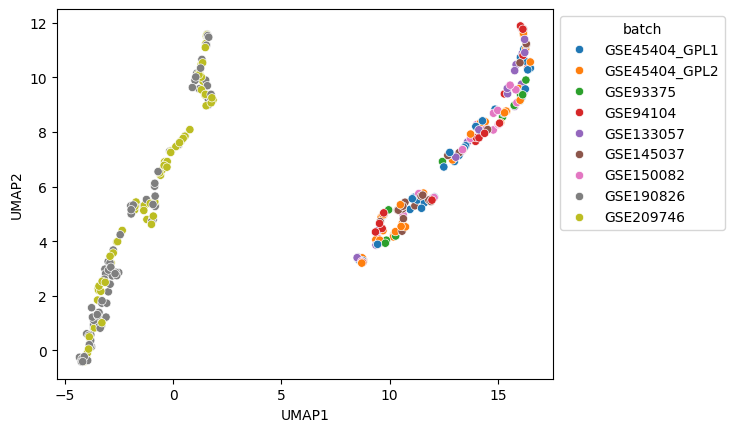

In [57]:
low_dimensional_representation_train = encoder.predict(X_train)

#verify the shape
print(low_dimensional_representation_train.shape)

#set up the umap

umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use

umap_result = umap_model.fit_transform(low_dimensional_representation_train)

#checking batch separation
current_label =  y_train['batch']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':current_label}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

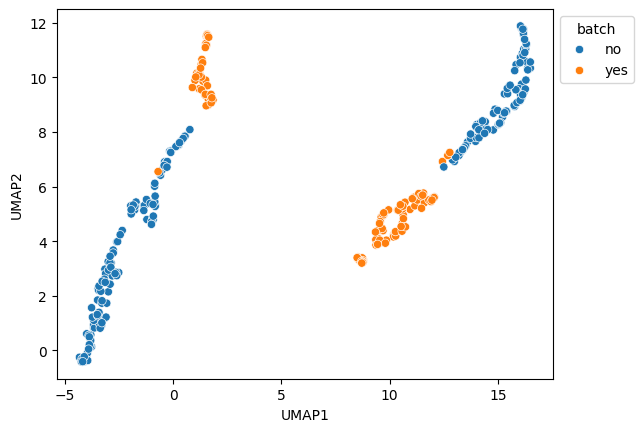

In [58]:
#checking batch separation
current_label = y_train['Response']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':current_label}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## umap representations of the test data set

3/3 [==============================] - 0s 5ms/step
(82, 128)


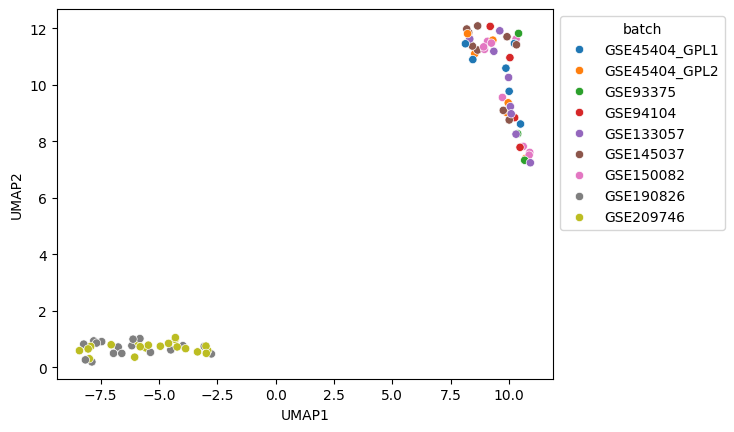

In [59]:
low_dimensional_representation_test = encoder.predict(X_test)

#verify the shape
print(low_dimensional_representation_test.shape)

#set up the umap

umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use

umap_result = umap_model.fit_transform(low_dimensional_representation_test)

#checking batch separation
current_label =  y_test['batch']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':current_label}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

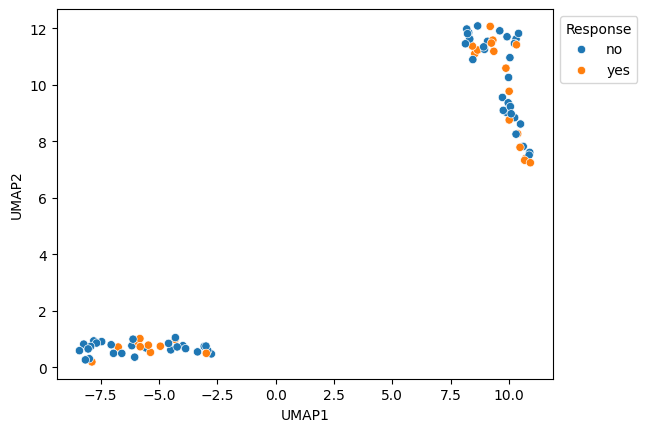

In [60]:
#checking batch separation
current_label = y_test['Response']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'Response':current_label}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Response')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## random forest classifer utilizing encodings from ANN model

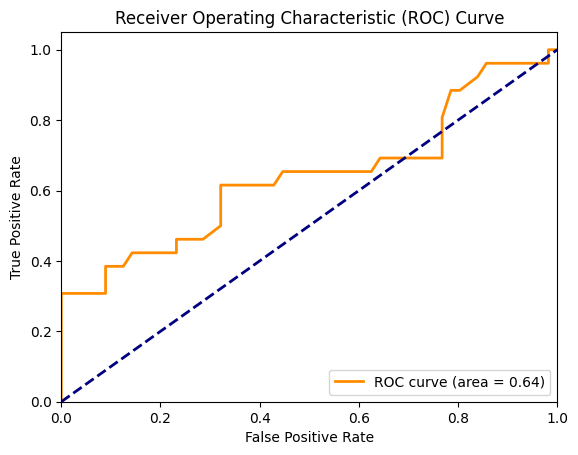

In [61]:
## random forest with test data, no transformation

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_outcome)

y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (class 1)

fpr, tpr, thresholds = roc_curve(y_test_outcome, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

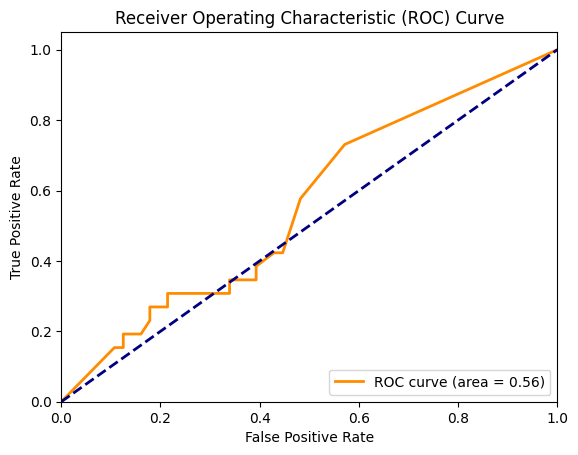

In [62]:
## random forest with transformed data

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(low_dimensional_representation_train, y_train_outcome)

y_pred_prob = clf.predict_proba(low_dimensional_representation_test)[:, 1]  # Probabilities for the positive class (class 1)

fpr, tpr, thresholds = roc_curve(y_test_outcome, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()